# Computing the forward model and recovering the spectrum with invert_spect_fmodel

gen_fm and invert_spect_fm are modules in pyklip/fmlib/extractSpec

gen_fm generates the forward model array given a pyklip instrument 
dataset and invert_spect_fm returns a spectrum in contrast units 
given the forward model array.

Generating the forward model:

## Set up

In [16]:
import glob
import numpy as np
import pyklip.instruments.GPI as GPI
import pyklip.fmlib.extractSpec as es
import pyklip.fm as fm
import pyklip.fakes as fakes
import matplotlib.pyplot as plt
%matplotlib inline

files = glob.glob("\path\to\files*.fits")
#files = [files[0], files[-1]] # For testing code
dataset = GPI.GPIData(files, highpass=True) # If testing code, can set highpass=False
# Need to specify a model PSF (either via this method, or any other way)
dataset.generate_psf_cube(20) 
model_psfs = dataset.psfs
#print model_psfs
# The units of your model PSF are important, the return spectrum will be
# relative to the input PSF model
print model_psfs.shape


###### Useful values based on dataset ######
N_frames = len(dataset.input)
N_cubes = np.size(np.unique(dataset.filenums))
nl = N_frames // N_cubes



Reading File: /Users/azgreenb/data/gpi/Reduced/131117/S20131117S0001_spdc_distorcorr.fits
Reading File: /Users/azgreenb/data/gpi/Reduced/131117/S20131117S0024_spdc_distorcorr.fits
(37, 20, 20)


## Calibrate stellar flux (GPI example)

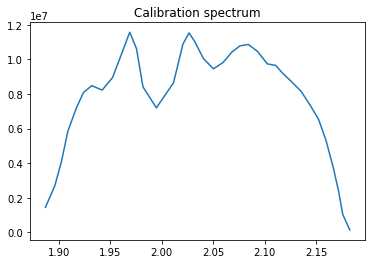

In [2]:
# First set up a PSF model and sums -- this is necessary for GPI because 
# dataset.spot_flux contains peak values of the satellite spots and we 
# have to correct for the full aperture. 
PSF_cube = dataset.psfs / dataset.psfs.sum(axis=(1,2))[:,None, None]
model_psf_sum = np.nansum(PSF_cube, axis=(1,2))
model_psf_peak = np.nanmax(PSF_cube, axis=(1,2))
# Now divide the sum by the peak for each wavelength slice
aper_over_peak_ratio = model_psf_sum/model_psf_peak

# star-to-spot calibration factor
band = dataset.prihdrs[0]['APODIZER'].split('_')[1]
spot_to_star_ratio = dataset.spot_ratio[band]
# DO NOT USE dataset.band !!! (always returns K1)

spot_peak_spectrum = \
        np.median(dataset.spot_flux.reshape(len(dataset.spot_flux)//nl, nl), axis=0)
calibfactor = aper_over_peak_ratio*spot_peak_spectrum / spot_to_star_ratio

# calibrated_PSF_model is the flux of the star in detector counts for each wavelength
calibrated_PSF_model = PSF_cube*calibfactor[:,None, None]
plt.title("Calibration spectrum")
plt.plot(np.unique(dataset.wvs), calibfactor)

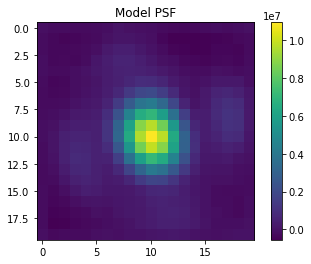

In [3]:
plt.title("Model PSF")
plt.imshow(calibrated_PSF_model.sum(axis=0), interpolation="nearest")
plt.colorbar()

## Compute the forward model

In [4]:
###### parameters you specify ######
pars = (45, 222) # separation and pa of companion
planet_sep, planet_pa = pars
numbasis = [10,] # "k_klip", a list of the k_klips you want to calculate
num_k_klip = len(numbasis) 
maxnumbasis = 100 # Max components to be calculated
movement = 2.0 # aggressiveness for choosing reference library
stamp_size = 10 # how big of a stamp around the companion in pixels
                      # stamp will be stamp_size**2 pixels
                # must be int type
numthreads=4 # number of threads, machine specific
spectra_template = None # a template spectrum, if you want
 

In [4]:

   
###### The forward model class ######
fm_class = es.ExtractSpec(dataset.input.shape,
                           numbasis,
                           planet_sep,
                           planet_pa,
                           calibrated_PSF_model,
                           np.unique(dataset.wvs),
                           stamp_size = stamp_size)

###### Now run KLIP! ######
fm.klip_dataset(dataset, fm_class,
                    fileprefix="fmspect",
                    annuli=[[planet_sep-stamp_size,planet_sep+stamp_size]],
                    subsections=[[(planet_pa-stamp_size)/180.*np.pi,\
                                  (planet_pa+stamp_size)/180.*np.pi]],
                    movement=movement,
                    numbasis = numbasis, 
                    maxnumbasis=maxnumbasis,
                    numthreads=numthreads,
                    spectrum=spectra_template,
                    save_klipped=True, highpass=False,
                    outputdir="demo_output/")

# Forward model is stored in dataset.fmout, this is how it is organized:
# the klipped psf
klipped = dataset.fmout[:,:,-1,:]
klipped_coadd = np.zeros((num_k_klip, nl, stamp_size*stamp_size))
# The rest is the forward model, dimensions:
# [num_k_klip, N_frames, N_frames,  stamp_size*stamp_size]
# If numbasis is a list, the first dimension will be the size of that list,
# a forward model calculated at each value of numbasis.

/Users/azgreenb/anaconda/lib/python2.7/site-packages/scipy/interpolate/fitpack2.py:1116: UserWarning: 
The coefficients of the spline returned have been computed as the
minimal norm least-squares solution of a (numerically) rank deficient
system (deficiency=129). If deficiency is large, the results may be
inaccurate. Deficiency may strongly depend on the value of eps.
  warnings.warn(message)


Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 314.159265359 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time
 100.00% of sector, 100.00% of total completed
Closing threadpool
Writing KLIPed Images to directory /Users/azgreenb/Dropbox/klip/demo_output


/Users/azgreenb/pythonmodules/pyklip/pyklip/fm.py:1779: RuntimeWarning: Mean of empty slice
  KLmode_cube = np.nanmean(dataset.output, axis=1)
/Users/azgreenb/pythonmodules/pyklip/pyklip/fm.py:1799: RuntimeWarning: Mean of empty slice
  KLmode_spectral_cubes = np.nanmean(klipped_spec, axis=1)


## Now we can recover the spectrum

In [5]:

# If you want to scale your spectrum by a calibration factor:
#units = "scaled"
#scaling_factor = my_calibration_factor
#e.g., for GPI this could be the star-to-spot ratio
# otherwise, the defaults are:
units = "natural" # returned relative to input PSF model
scaling_factor=1.0 # not used if units not set to "scaled"


exspect, fm_matrix = es.invert_spect_fmodel(dataset.fmout, dataset, units=units,
                                            scaling_factor=scaling_factor, method="leastsq")


(37, 100)


/Users/azgreenb/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


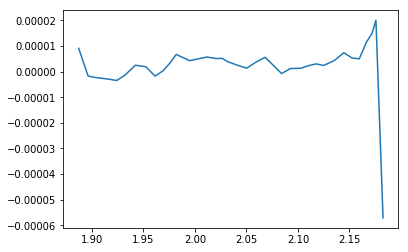

In [6]:

# Expecting this to be junk, only using 2 slices of data
plt.plot(np.unique(dataset.wvs), exspect[0,:])

## Simulating a fake planet & recovering the spectrum:

In [5]:
# PSF model template for each cube observation, copies of the PSF model:
inputpsfs = np.tile(calibrated_PSF_model, (N_cubes, 1, 1))
bulk_contrast = 1e-2
fake_psf = inputpsfs*bulk_contrast
fake_flux = bulk_contrast*np.ones(dataset.wvs.shape)
#for ll in range(N_cubes):
#    fake_flux[ll*nl:(ll+1)*nl] = exspect[0, :]
pa = planet_pa+180

tmp_dataset = GPI.GPIData(files, highpass=False)
fakes.inject_planet(tmp_dataset.input, tmp_dataset.centers, fake_psf,\
                                tmp_dataset.wcs, planet_sep, pa)

fm_class = es.ExtractSpec(tmp_dataset.input.shape,
                           numbasis,
                           planet_sep,
                           pa,
                           calibrated_PSF_model,
                           np.unique(dataset.wvs),
                           stamp_size = stamp_size)

fm.klip_dataset(tmp_dataset, fm_class,
                    fileprefix="fakespect",
                    annuli=[[planet_sep-stamp_size,planet_sep+stamp_size]],
                    subsections=[[(pa-stamp_size)/180.*np.pi,\
                                  (pa+stamp_size)/180.*np.pi]],
                    movement=movement,
                    numbasis = numbasis, 
                    maxnumbasis=maxnumbasis,
                    numthreads=numthreads,
                    spectrum=spectra_template,
                    save_klipped=True, highpass=True,
                    outputdir="demo_output/")

Reading File: /Users/azgreenb/data/gpi/Reduced/131117/S20131117S0001_spdc_distorcorr.fits
Reading File: /Users/azgreenb/data/gpi/Reduced/131117/S20131117S0024_spdc_distorcorr.fits


/Users/azgreenb/anaconda/lib/python2.7/site-packages/scipy/interpolate/fitpack2.py:1116: UserWarning: 
The coefficients of the spline returned have been computed as the
minimal norm least-squares solution of a (numerically) rank deficient
system (deficiency=129). If deficiency is large, the results may be
inaccurate. Deficiency may strongly depend on the value of eps.
  warnings.warn(message)


Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 314.159265359 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time
 100.00% of sector, 100.00% of total completed
Closing threadpool
Writing KLIPed Images to directory /Users/azgreenb/Dropbox/klip/demo_output


/Users/azgreenb/pythonmodules/pyklip/pyklip/fm.py:1779: RuntimeWarning: Mean of empty slice
  KLmode_cube = np.nanmean(dataset.output, axis=1)
/Users/azgreenb/pythonmodules/pyklip/pyklip/fm.py:1799: RuntimeWarning: Mean of empty slice
  KLmode_spectral_cubes = np.nanmean(klipped_spec, axis=1)


(37, 100)


/Users/azgreenb/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


(0, 0.02)

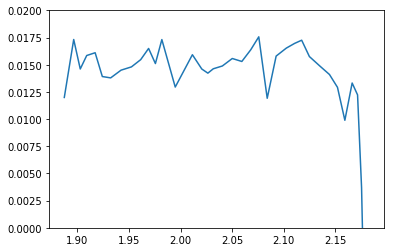

In [6]:
fake_spect, fakefm = es.invert_spect_fmodel(tmp_dataset.fmout, tmp_dataset, method="leastsq",
                                           units="scaled", scaling_factor=2.0)
plt.plot(np.unique(tmp_dataset.wvs), fake_spect[0,:])
plt.ylim(0, 2e-2)

If everything is working properly the spectrum should be a flat line at 1e-2. This is pretty "bright" so we expect some flux loss. 

## Comparing the klipped data to the forward model

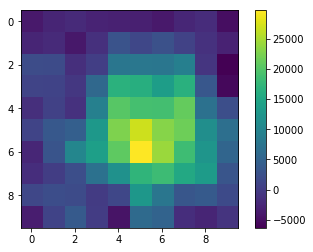

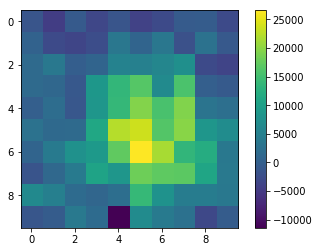

In [15]:
klipped_data = tmp_dataset.fmout[:,:,-1, :]
klipped_coadd = np.zeros((num_k_klip, nl, stamp_size*stamp_size))
for ll in range(N_cubes):
    klipped_coadd = klipped_coadd + klipped_data[0, ll*nl:(ll+1)*nl, :]
# turn it back into a 2D arrat at each wavelength, k_klip
klipped_coadd.shape = [nl, int(stamp_size), int(stamp_size)]
plt.imshow(klipped_coadd.sum(axis=0), interpolation="nearest")
plt.colorbar()

plt.figure()
k=0
fm_image_k = np.dot(fakefm[k,:,:], fake_spect[k].transpose()).reshape(nl, stamp_size, stamp_size)
plt.imshow(fm_image_k.sum(axis=0), interpolation="nearest")
plt.colorbar()

## Calculating errorbars

This just takes the code from above and puts it in a loop

In [ ]:
def recover_fake(files, position, fake_flux):
    # We will need to create a new dataset each time.
    
    # PSF model template for each cube observation, copies of the PSF model:
    inputpsfs = np.tile(calibrated_PSF_model, (N_cubes, 1, 1))
    bulk_contrast = 1e-2
    fake_psf = inputpsfs*fake_flux[0,None,None]
    pa = planet_pa+180

    tmp_dataset = GPI.GPIData(files, highpass=False)
    fakes.inject_planet(tmp_dataset.input, tmp_dataset.centers, fake_psf,\
                                    tmp_dataset.wcs, planet_sep, pa)

    fm_class = es.ExtractSpec(tmp_dataset.input.shape,
                               numbasis,
                               planet_sep,
                               pa,
                               calibrated_PSF_model,
                               np.unique(dataset.wvs),
                               stamp_size = stamp_size)

    fm.klip_dataset(tmp_dataset, fm_class,
                        fileprefix="fakespect",
                        annuli=[[planet_sep-stamp_size,planet_sep+stamp_size]],
                        subsections=[[(pa-stamp_size)/180.*np.pi,\
                                      (pa+stamp_size)/180.*np.pi]],
                        movement=movement,
                        numbasis = numbasis, 
                        maxnumbasis=maxnumbasis,
                        numthreads=numthreads,
                        spectrum=spectra_template,
                        save_klipped=True, highpass=True,
                        outputdir="demo_output/")
    fake_spect, fakefm = es.invert_spect_fmodel(tmp_dataset.fmout, tmp_dataset, method="leastsq",
                                           units="scaled", scaling_factor=2.0)
    del tmp_dataset
    return fake_spect

# This could take a long time to run
# Define a set of PAs to put in fake sources
npas = 11
pas = (np.linspace(planet_pa, planet_pa+360, num=npas+2)%360)[1:-1]

# For numbasis "k"
# repeat the spectrum over each cube in the dataset
input_spect = np.tile(exspect[k,:], N_cubes)[0,:]
fake_spectra = np.zeros((npas, nl))
for p, pa in enumerate(pas):
    fake_spectra[p,:] = recover_fake(files, (planet_sep, pa), input_spect)

#Other details, like the forward model or klipped data for the injected signal could be useful.


# If the real companion signal is too bright, the forward model may fail to capture all the flux
# It could be helpful to look at whether the recovered spectra for the simulated signal are 
# evenly distributed around the simulated spectrum or if they are systematically lower flux::

offset[ii] = estim_spec[ii] - np.median(fake_spectra, axis=0)
